### Load libraries

In [2]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import json #Files saved from google takeout were in json format
import os

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
stop_words = set(stopwords.words(['english','spanish']))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jahdovanterpool/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jahdovanterpool/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jahdovanterpool/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jahdovanterpool/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Gathering the Data

In [2]:
# Load json file from my files
# Rename files so they could be better organized
folder_path = '/Users/jahdovanterpool/Downloads/Sylvia/reviews'


def rename_json_files(folder_path):
    json_files = sorted([f for f in os.listdir(folder_path) if f.endswith('json')])
    renamed = []

    for i, old_name in enumerate(json_files):
        old_path = os.path.join(folder_path,old_name)
        new_name = f'review-{i:03}.json'
        new_path = os.path.join(folder_path,new_name)
        os.rename(old_path,new_path)
        print(f'Renamed {old_name} --> {new_name}')
        renamed.append(new_name)
    return renamed


file_name_change = rename_json_files(folder_path)
print(file_name_change)

Renamed review-000.json --> review-000.json
Renamed review-001.json --> review-001.json
Renamed review-002.json --> review-002.json
Renamed review-003.json --> review-003.json
Renamed review-004.json --> review-004.json
Renamed review-005.json --> review-005.json
Renamed review-006.json --> review-006.json
Renamed review-007.json --> review-007.json
Renamed review-008.json --> review-008.json
Renamed review-009.json --> review-009.json
Renamed review-010.json --> review-010.json
Renamed review-011.json --> review-011.json
Renamed review-012.json --> review-012.json
Renamed review-013.json --> review-013.json
Renamed review-014.json --> review-014.json
['review-000.json', 'review-001.json', 'review-002.json', 'review-003.json', 'review-004.json', 'review-005.json', 'review-006.json', 'review-007.json', 'review-008.json', 'review-009.json', 'review-010.json', 'review-011.json', 'review-012.json', 'review-013.json', 'review-014.json']


In [3]:
# Combine the json files and create one dataframe

def merge_json_in_folder(folder_path):
    merged_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            try:
                data = pd.read_json(file_path)
                merged_data = pd.concat([merged_data, data], ignore_index=True)
            except Exception as e:
                print(f"Could not read {filename}: {e}")
    merged_data.to_json('merged.json', orient='records', lines=True)
    return merged_data


merged_df = merge_json_in_folder(folder_path)
merged_df.head()

,reviews
0,{'reviewer': {'displayName': 'Angela Pressley'...
1,{'reviewer': {'displayName': 'Tywan Robinson'}...
2,"{'reviewer': {'displayName': 'roy burgess'}, '..."
3,"{'reviewer': {'displayName': 'DDA'}, 'starRati..."
4,"{'reviewer': {'displayName': 'Willie Eady'}, '..."


In [4]:
# Convert Json semi structured data puts it into a proper dataframe
# Fill missing values replies and comments with 'No reply' or just there star rating

flat_df = pd.json_normalize(merged_df['reviews'])

flat_df.rename(columns={
    'starRating':'Rating',
    'comment': 'Comment',
    'createTime': 'Date posted',
    'updateTime': 'Updated',
    'name': 'ReviewID',
    'reviewer.displayName':'Reviewer',
    'reviewReply.comment': 'Reply',
    'reviewReply.updateTime': 'ReplyUpdate'
},inplace=True)


flat_df['Reply'] = flat_df['Reply'].fillna('No Reply')
flat_df.loc[:,'Comment'] = flat_df.apply(
    lambda row: f"{row['Rating']} star" if pd.isna(row['Comment']) else row['Comment'],
    axis = 1
)

flat_df.head(100)

,Rating,Comment,Date posted,Updated,ReviewID,Reviewer,Reply,ReplyUpdate
0,TWO,Customer service was very nice. The prices wer...,2022-01-18T16:52:22.018400Z,2022-01-18T16:52:22.018400Z,accounts/113125786415732178818/locations/11630...,Angela Pressley,No Reply,NaN
1,FIVE,FIVE star,2022-01-06T18:13:54.656825Z,2022-01-06T18:13:54.656825Z,accounts/113125786415732178818/locations/11630...,Tywan Robinson,No Reply,NaN
2,FOUR,FOUR star,2019-09-10T21:10:15.208764Z,2022-01-06T17:03:22.134433Z,accounts/113125786415732178818/locations/11630...,roy burgess,No Reply,NaN
3,FIVE,"Oxtails, wow, best around 3 neighboring counti...",2022-01-05T18:22:16.895742Z,2022-01-05T18:22:16.895742Z,accounts/113125786415732178818/locations/11630...,DDA,No Reply,NaN
4,FIVE,FIVE star,2021-12-10T19:37:43.238743Z,2021-12-10T19:37:43.238743Z,accounts/113125786415732178818/locations/11630...,Willie Eady,No Reply,NaN
...,...,...,...,...,...,...,...,...
95,FIVE,Best Jamaican food in Poughkeepsie I’ve been g...,2022-03-06T15:05:54.053857Z,2022-03-06T15:05:54.053857Z,accounts/113125786415732178818/locations/11630...,Roberto Ortiz,Thank you,2023-11-18T00:16:52.471179Z
96,FIVE,FIVE star,2022-02-25T07:28:45.738440Z,2022-02-25T07:28:45.738440Z,accounts/113125786415732178818/locations/11630...,Norman Smith,Thank you,2023-11-18T00:17:00.620590Z
97,FIVE,Always an enjoyable experience but be prepared...,2022-02-08T18:13:29.797840Z,2022-02-08T18:13:29.797840Z,accounts/113125786415732178818/locations/11630...,Meaghan Battle,Thank you,2023-11-18T00:17:14.042470Z
98,FIVE,FIVE star,2021-08-31T22:46:17.008788Z,2022-02-08T11:36:50.719964Z,accounts/113125786415732178818/locations/11630...,Legacy Mission,No Reply,NaN


In [5]:
# Check for null values
flat_df.isnull().sum()

Rating           0
Comment          0
Date posted      0
Updated          0
ReviewID         0
Reviewer         0
Reply            0
ReplyUpdate    229
dtype: int64

In [6]:
# Create table that just has the comments which received replies
replied_df = flat_df[flat_df['Reply'] != 'No Reply']
replied_df.head()

,Rating,Comment,Date posted,Updated,ReviewID,Reviewer,Reply,ReplyUpdate
80,FIVE,"Popped In, with my brother, Jerome. Visiting P...",2022-08-09T23:12:21.137862Z,2022-08-09T23:14:01.290592Z,accounts/113125786415732178818/locations/11630...,Charles Rhodd,Thank you so much for returning and showing us...,2022-08-28T14:52:13.194467Z
81,FIVE,Excellent food and excellent service. Very pol...,2022-07-27T06:38:25.947549Z,2022-07-27T06:38:25.947549Z,accounts/113125786415732178818/locations/11630...,stephen gould,Thank you so much,2022-09-03T02:06:11.953185Z
82,FIVE,A place you must go to eat.,2018-06-02T10:21:07.801Z,2022-07-01T20:11:31.829372Z,accounts/113125786415732178818/locations/11630...,rosem fearon,Thank you so much,2022-09-03T02:06:20.125970Z
83,FOUR,FOUR star,2022-06-24T23:24:05.566380Z,2022-06-24T23:24:05.566380Z,accounts/113125786415732178818/locations/11630...,Alizabeth Holland,Thank you,2022-09-03T02:06:31.037348Z
84,FIVE,The food was great!,2022-06-14T12:52:24.799537Z,2022-06-14T12:52:24.799537Z,accounts/113125786415732178818/locations/11630...,odetta bailey,Thank you,2023-09-21T23:27:00.887095Z


In [7]:
# Save data
flat_df.to_csv('/Users/jahdovanterpool/Downloads/Sylvia/local_sentiment_project.csv')

### Loading data & text preprocessing

In [7]:
# Load data and drop some columns
df = pd.read_csv('/Users/jahdovanterpool/Downloads/Sylvia/local_sentiment_project.csv',index_col=0)
df.drop(['ReplyUpdate','ReviewID','Updated','Reviewer','Reply'],axis=1, inplace=True)

df.head()

,Rating,Comment,Date posted
0,TWO,Customer service was very nice. The prices wer...,2022-01-18T16:52:22.018400Z
1,FIVE,FIVE star,2022-01-06T18:13:54.656825Z
2,FOUR,FOUR star,2019-09-10T21:10:15.208764Z
3,FIVE,"Oxtails, wow, best around 3 neighboring counti...",2022-01-05T18:22:16.895742Z
4,FIVE,FIVE star,2021-12-10T19:37:43.238743Z


In [8]:
# Convert ratings to integers
rating_map = {
    'TWO':2,
    'FIVE':5,
    'FOUR':4,
    'THREE':3,
    'ONE':1
              }

df['Stars'] = df['Rating'].map(rating_map)
df.drop('Rating',axis=1,inplace=True)
df.head()

,Comment,Date posted,Stars
0,Customer service was very nice. The prices wer...,2022-01-18T16:52:22.018400Z,2
1,FIVE star,2022-01-06T18:13:54.656825Z,5
2,FOUR star,2019-09-10T21:10:15.208764Z,4
3,"Oxtails, wow, best around 3 neighboring counti...",2022-01-05T18:22:16.895742Z,5
4,FIVE star,2021-12-10T19:37:43.238743Z,5


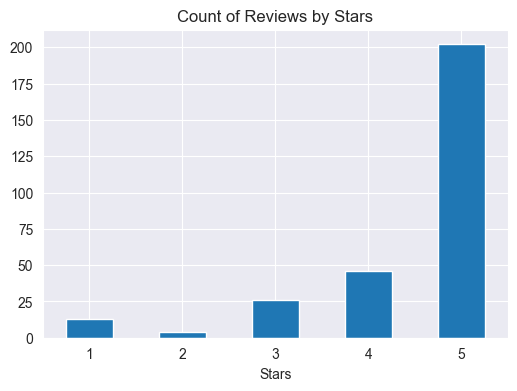

In [9]:
# Plot the count of each rating
score_counts = df['Stars'].value_counts()
ax = score_counts.sort_index(ascending=True).plot(kind='bar',
                                    title = 'Count of Reviews by Stars',
                                    figsize = (6,4),
                                    rot = 360
                                    )

plt.grid(True)
plt.show()

In [12]:
# Reorder the columns
df = df[['Stars','Comment', 'clean_text','Date posted']]
df.head()

,Stars,Comment,clean_text,Date posted
0,2,Customer service was very nice. The prices wer...,customer service nice prices ok good caribbean...,2022-01-18T16:52:22.018400Z
1,5,FIVE star,five star,2022-01-06T18:13:54.656825Z
2,4,FOUR star,four star,2019-09-10T21:10:15.208764Z
3,5,"Oxtails, wow, best around 3 neighboring counti...",oxtails wow best around 3 neighboring counties...,2022-01-05T18:22:16.895742Z
4,5,FIVE star,five star,2021-12-10T19:37:43.238743Z


In [51]:
# Clean text
def clean_text(text):
    if not isinstance(text,str): # Ensures that the text is actually a string
        return "" # Returns an empty string in cases where input was not text

    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)

    tokens = word_tokenize(text) # Breaks the string into a list of words

    cleaned_tokens = [
        lemmatizer.lemmatize(word,pos='v')
        for word in tokens
        if word not in stop_words and word.isalpha()
    ]
    return ' '.join(cleaned_tokens)

df['clean_text'] = df['Comment'].apply(clean_text)
df.head()

,Stars,Comment,clean_text,Date posted
0,2,Customer service was very nice. The prices wer...,customer service nice price ok good caribbean ...,2022-01-18T16:52:22.018400Z
1,5,FIVE star,five star,2022-01-06T18:13:54.656825Z
2,4,FOUR star,four star,2019-09-10T21:10:15.208764Z
3,5,"Oxtails, wow, best around 3 neighboring counti...",oxtails wow best around neighbor counties stop...,2022-01-05T18:22:16.895742Z
4,5,FIVE star,five star,2021-12-10T19:37:43.238743Z


In [52]:
# Manually checking that comments were cleaned
import random
i = random.randint(0,len(df))
print(i)
print("Original:", df.loc[i, 'Comment'])
print('\n')
print('Cleaned:', df.loc[i, 'clean_text'])

262
Original: Quick service, clean environment. Friendly servers. 100% recommend.


Cleaned: quick service clean environment friendly servers recommend


In [53]:
df.to_csv('/Users/jahdovanterpool/Downloads/Sylvia/local_sentiment_project.csv', index=False)

### Sentiment - Vader

In [45]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [83]:
vader_df = pd.read_csv('/Users/jahdovanterpool/Downloads/Sylvia/local_sentiment_project.csv', index_col=False)
vader_df.sample(10)

,Stars,Comment,clean_text,Date posted
15,4,"Excellent jerk chicken, oxtails and curry goat...",excellent jerk chicken oxtails curry goat cert...,2021-09-25T23:33:20.037293Z
83,4,FOUR star,four star,2022-06-24T23:24:05.566380Z
24,5,FIVE star,five star,2021-01-06T17:52:03.981947Z
114,5,"As always, the food was fabulous... we had the...",always food fabulous oxtails rice bean coconut...,2020-07-03T22:18:11.948560Z
283,4,FOUR star,four star,2022-11-15T08:43:03.079427Z
3,5,"Oxtails, wow, best around 3 neighboring counti...",oxtails wow best around neighbor counties stop...,2022-01-05T18:22:16.895742Z
107,5,FIVE star,five star,2020-08-04T03:06:13.534453Z
183,1,I’m standing in line waiting to be helped for ...,stand line wait help mins owner come help pers...,2023-10-19T21:07:53.013090Z
280,5,FIVE star,five star,2023-03-06T12:35:33.593156Z
128,5,Very good food.,good food,2016-04-10T15:51:47.695Z


In [84]:
vader_df['sentiment_score'] = vader_df['clean_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

def star_sentiment(stars):
    if stars >= 4:
        return 'Positive'
    elif stars == 3:
        return 'Neutral'
    else:
        return 'Negative'

def label_sentiment(score):
    if score >= 0.5:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

vader_df['sentiment_label'] = vader_df['sentiment_score'].apply(lambda x: label_sentiment(x))
vader_df['star_sentiment_label'] = vader_df['Stars'].apply(lambda x: star_sentiment(x))

df.sample(10)

,Stars,Comment,clean_text,Date posted,sentiment_score,sentiment_label,star_sentiment_label,match
254,5,"Spectacular food, curry goat and jerk chicken ...",spectacular food curry goat jerk chicken highl...,2019-03-22T17:05:20.124934Z,0.9396,Positive,Positive,True
196,3,THREE star,three star,2018-02-13T01:39:10.849Z,0.0000,Neutral,Neutral,True
82,5,A place you must go to eat.,place must go eat,2018-06-02T10:21:07.801Z,0.0000,Neutral,Positive,False
179,4,Good food some days u can order quick some day...,good food days u order quick days u wait line ...,2024-01-14T23:48:58.832284Z,0.7003,Positive,Positive,True
61,4,Great food and everyone was so friendly,great food everyone friendly,2020-02-27T12:58:04.031835Z,0.8074,Positive,Positive,True
23,5,FIVE star,five star,2021-01-09T15:54:11.519888Z,0.0000,Neutral,Positive,False
17,5,FIVE star,five star,2021-09-22T13:50:25.671941Z,0.0000,Neutral,Positive,False
163,5,When you eat there..its like you are in jamaica!,eat like jamaica,2021-06-27T15:40:16.928016Z,0.3612,Neutral,Positive,False
195,5,This place has authentic Jamaican food. The f...,place authentic jamaican food food tasty servi...,2018-02-22T20:41:43.320Z,0.5719,Positive,Positive,True
63,5,I literally live for their soups every winter!...,literally live soup every winter love keep tra...,2020-02-06T21:17:58.051975Z,0.9274,Positive,Positive,True


In [85]:
vader_df['match'] = vader_df['sentiment_label'] == vader_df['star_sentiment_label']
vader_df['match'].value_counts()

match
True     146
False    145
Name: count, dtype: int64

<Axes: title={'center': 'Agreement Rate Between Rating and Text Sentiment'}, xlabel='Stars'>

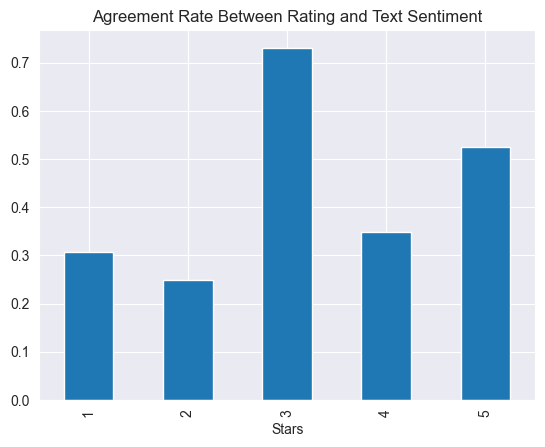

In [86]:
agreement_by_star = vader_df.groupby('Stars')['match'].mean()
agreement_by_star.plot(kind='bar', title='Agreement Rate Between Rating and Text Sentiment')

### Sentiment - Transformer

In [3]:
df = pd.read_csv('/Users/jahdovanterpool/Downloads/Sylvia/local_sentiment_project.csv', index_col=False)
df.sample(10)

,Stars,Comment,clean_text,Date posted
24,5,FIVE star,five star,2021-01-06T17:52:03.981947Z
157,3,Forgot some of my food that i ordered and they...,forget food order never really mess order,2021-08-10T20:59:01.975673Z
238,5,Best Jamaican restaurant in Dutchess County!!!...,best jamaican restaurant dutchess county food ...,2025-01-17T18:59:04.089718Z
239,5,FIVE star,five star,2024-12-16T13:10:08.422044Z
12,3,THREE star,three star,2021-10-14T16:18:51.077650Z
235,5,FIVE star,five star,2025-02-18T21:02:38.986581Z
123,4,Very nice family-owned restaurant. Love the fo...,nice family own restaurant love food faves dai...,2017-05-28T03:05:26.035Z
124,5,This is the best Jamaican restaurant in NY..Wo...,best jamaican restaurant ny wonderful experien...,2017-02-16T22:46:00.738Z
195,5,This place has authentic Jamaican food. The f...,place authentic jamaican food food tasty servi...,2018-02-22T20:41:43.320Z
164,3,"The food was so-so. I got the stewed chicken, ...",food get stew chicken cabbage white rice chick...,2021-06-25T18:58:33.792708Z


In [5]:
import warnings
warnings.filterwarnings('ignore')
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

In [10]:
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, framework='pt')

df['sentiment'] = df['clean_text'].apply(lambda x: int(sentiment_pipeline(x[:512])[0]['label'].split()[0]))
df.head()

Device set to use mps:0


,Stars,Comment,clean_text,Date posted,sentiment
0,2,Customer service was very nice. The prices wer...,customer service nice price ok good caribbean ...,2022-01-18T16:52:22.018400Z,3
1,5,FIVE star,five star,2022-01-06T18:13:54.656825Z,5
2,4,FOUR star,four star,2019-09-10T21:10:15.208764Z,4
3,5,"Oxtails, wow, best around 3 neighboring counti...",oxtails wow best around neighbor counties stop...,2022-01-05T18:22:16.895742Z,5
4,5,FIVE star,five star,2021-12-10T19:37:43.238743Z,5


In [11]:
df.columns

Index(['Stars', 'Comment', 'clean_text', 'Date posted', 'sentiment'], dtype='object')

In [12]:
sentiment_df = df[['clean_text','Stars','sentiment']]
sentiment_df.head()

,clean_text,Stars,sentiment
0,customer service nice price ok good caribbean ...,2,3
1,five star,5,5
2,four star,4,4
3,oxtails wow best around neighbor counties stop...,5,5
4,five star,5,5


In [13]:
sentiment_df['match'] = sentiment_df['sentiment'] == sentiment_df['Stars']
sentiment_df['match'].value_counts()

match
True     230
False     61
Name: count, dtype: int64

<Axes: title={'center': 'Agreement Rate Between Rating and Text Sentiment'}, xlabel='Stars'>

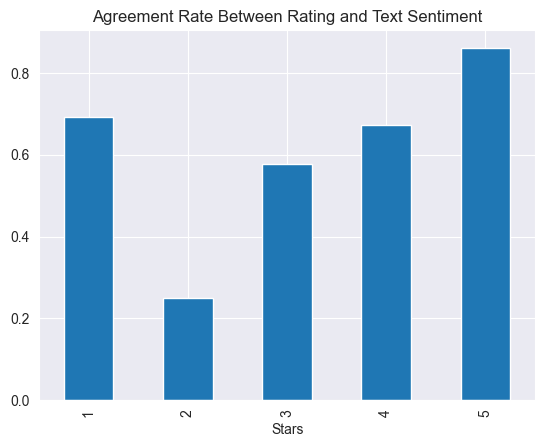

In [14]:
agreement_by_star = sentiment_df.groupby('Stars')['match'].mean()
agreement_by_star.plot(kind='bar', title='Agreement Rate Between Rating and Text Sentiment')

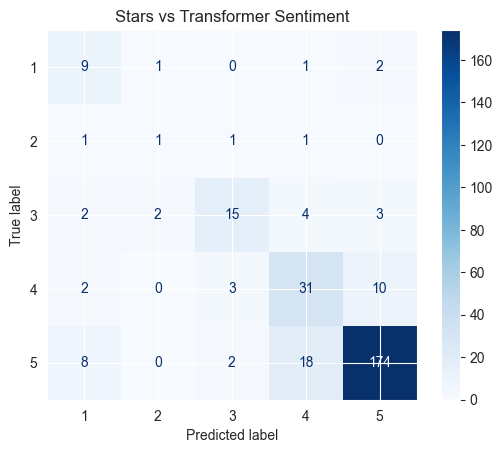

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Visualizing the true and predicted stars
cm = confusion_matrix(sentiment_df['Stars'], sentiment_df['sentiment'], labels=[1, 2, 3, 4, 5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
disp.plot(cmap='Blues')
plt.title('Stars vs Transformer Sentiment')
plt.show()



### Keywords

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=20)

In [47]:
 def get_keywords(corpus):
     X = vectorizer.fit_transform(corpus)
     keywords = vectorizer.get_feature_names_out()
     counts = X.sum(axis=0).A1
     return sorted(zip(keywords, counts), key=lambda x: x[1], reverse=True)

In [49]:
positive_comments = sentiment_df[sentiment_df['Stars'] >= 4]['clean_text']
negative_comments = sentiment_df[sentiment_df['Stars'] <= 2]['clean_text']

print("Top Positive Keywords")
positive = {}
for word, count in get_keywords(positive_comments):
    positive[word] = int(count)
print(positive)

print("\n")
print("Top Negative Keywords")
negative = {}
for word, count in get_keywords(negative_comments):
    negative[word] = int(count)
print(negative)

Top Positive Keywords
{'food': 114, 'star': 104, 'good': 45, 'jamaican': 45, 'great': 35, 'best': 32, 'service': 26, 'love': 24, 'chicken': 22, 'delicious': 20, 'friendly': 20, 'place': 20, 'restaurant': 19, 'eat': 16, 'oxtail': 16, 'poughkeepsie': 16, 'jerk': 15, 'staff': 15, 'rice': 14, 'people': 13}


Top Negative Keywords
{'food': 8, 'taste': 8, 'rice': 7, 'like': 5, 'disappoint': 4, 'goat': 4, 'good': 4, 'peas': 4, 'help': 3, 'horrible': 3, 'order': 3, 'oxtails': 3, 'person': 3, 'restaurant': 3, 'rude': 3, 'season': 3, 'service': 3, 'soup': 3, 'star': 3, 'time': 3}


In [50]:
def plot_keywords(keyword_dict, title):
    keywords = list(keyword_dict.keys())
    counts = list(keyword_dict.values())
    plt.figure(figsize=(10,5))
    plt.barh(keywords[::-1], counts[::-1])
    plt.title(title)
    plt.xlabel("Mentions")
    plt.tight_layout()
    plt.show()


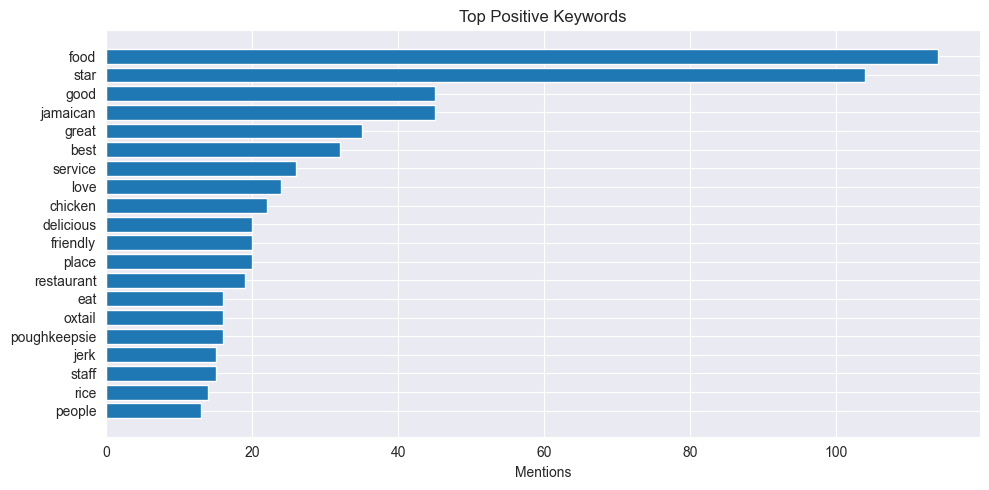

In [53]:
plot_keywords(positive, "Top Positive Keywords")


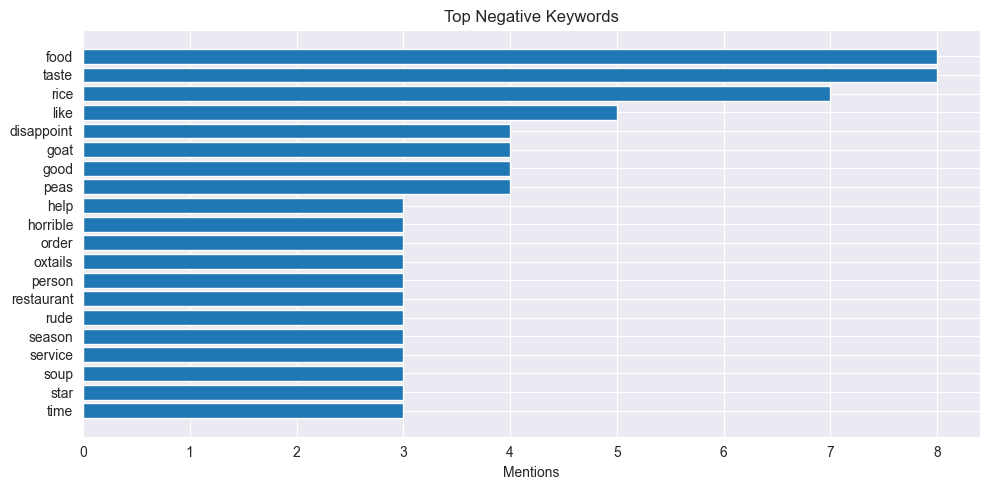

In [55]:
plot_keywords(negative, "Top Negative Keywords")


### Word searching in comments

In [84]:
def find_comments(keywords, df , column='Comment', n=50):
    """
    Search for reviews that mention a word or list of words.

    Args:
        keywords (str or list): A single word/phrase or list of them
        df (DataFrame): Your reviews DataFrame
        column (str): Cleaned text column
        original_column (str): Raw text column
        n (int): How many comments to return

    Returns:
        Sample of matching comments or message if none found
    """
    if isinstance(keywords, str):
        keywords = [keywords]

    pattern = '|'.join(keywords)
    matches = df[df[column].str.contains(pattern, case=False, na=False)]

    if matches.empty:
        return f"No matches found for: {', '.join(keywords)}"

    return matches[[column]].sample(min(n, len(matches)))

pd.set_option('display.width', 0)  # Adjust to terminal width
find_comments("staff", df)

In [85]:
pd.set_option('display.width', 0)  # Adjust to terminal width
find_comments("staff", df)


,Comment
215,NICEST PEOPLE HERE! Fantastic food. Every time...
101,Best authentic Jamaican food in Poughkeepsie. ...
285,"Great atmosphere, lovely staff and amazing ser..."
116,I stop in to get Jamaican beef patties wheneve...
238,Best Jamaican restaurant in Dutchess County!!!...
44,The food is simply delicious...but make sure y...
37,Food was good. Staff were cordial. Jerk chicke...
251,Good food. Convenient location. Friendly staff.
45,Excellent curry chicken! Very friendly staff!
246,"Staff here has very little personal skills, th..."


,clean_text,Stars,sentiment,match
0,customer service nice price ok good caribbean ...,2,3,False
1,five star,5,5,True
2,four star,4,4,True
3,oxtails wow best around neighbor counties stop...,5,5,True
4,five star,5,5,True
...,...,...,...,...
286,four star,4,4,True
287,last night stop sylvia jamaican restaurant see...,5,1,False
288,good ol fine jerk service great marinade one best,5,5,True
289,food exceptionally delicious service cordial kind,5,5,True


###

In [88]:
sentiment_df.to_csv('/Users/jahdovanterpool/Downloads/sentiment_df.csv')